In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2 as cv
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.export import ExportArchive

2024-12-01 16:44:20.385908: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733067860.466316     898 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733067860.486985     898 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-01 16:44:20.664578: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
images_csv = pd.read_csv('data.csv')

In [3]:
images_csv = images_csv[['path', 'label']]
images_csv.head()

,path,label
0,Surprise/1bd930d6a1c717c11be33db74823f661cb53f...,Surprise
1,Surprise/cropped_emotions.100096~12fffff.png,Surprise
2,Surprise/0df0e470e33093f5b72a8197fa209d684032c...,Surprise
3,Surprise/cropped_emotions.260779~12fffff.png,Surprise
4,Surprise/cropped_emotions.263616~12fffff.png,Surprise


In [4]:
to_drop = images_csv[images_csv["label"] == "Ahegao"].index
images_csv = images_csv.drop(to_drop)

In [5]:
emotions = images_csv['label'].unique()
emotions_dic = {}
for index, emotion in enumerate(emotions):
    emotions_dic[emotion] = index

print(emotions_dic)

{'Surprise': 0, 'Sad': 1, 'Happy': 2, 'Neutral': 3, 'Angry': 4}


In [6]:
e_images = images_csv.replace(emotions_dic)

/tmp/ipykernel_898/2357465474.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  e_images = images_csv.replace(emotions_dic)


In [7]:
Sizes = []
for i in e_images['path']:
    image = cv.imread(f'dataset/{i}')
    height = image.shape[0]
    width = image.shape[1]
    Sizes.append(height*width)

In [8]:
e_images.insert(2, 'Sizes', Sizes)

In [9]:
diffrence = 100000
photo_filter = (e_images['Sizes'] >= diffrence)
e_images_filtered = e_images.loc[photo_filter]
e_images_filtered

,path,label,Sizes
0,Surprise/1bd930d6a1c717c11be33db74823f661cb53f...,0,230400
4,Surprise/cropped_emotions.263616~12fffff.png,0,187833
7,Surprise/0a15c44d8be6cc71cd9d8ab595266e5147459...,0,459684
9,Surprise/cropped_emotions.263517~12fffff.png,0,166160
10,Surprise/cropped_emotions.265653~12fffff.png,0,128310
...,...,...,...
15439,Angry/cropped_emotions.571531~angry.png,4,412125
15440,Angry/cropped_emotions.157999~angry.png,4,106110
15441,Angry/cropped_emotions.231380~angry.png,4,194530
15442,Angry/cropped_emotions.232172~angry.png,4,350620


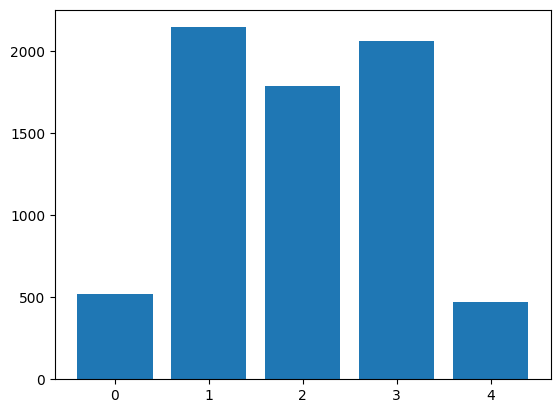

In [10]:
photos_by_emotions = e_images_filtered.groupby('label').count()
plt.bar(photos_by_emotions.index, photos_by_emotions['path']);

In [11]:
X = e_images_filtered['path']
y = e_images_filtered['label']

In [12]:
X_images = []
for i in X:
    image = cv.imread(f'dataset/{i}')
    rgb_image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    resize_image = cv.resize(rgb_image, (100, 100))
    std_image = resize_image / 255.0
    X_images.append(std_image)

X_images_np = np.array(X_images).astype(dtype='float32')
y_np = y.to_numpy().astype(dtype='long')

In [13]:
Images = []
for image in range(5):
    index = np.where(y_np == image)[0][0]
    Images.append(X_images_np[index])

In [14]:
Images[0].shape

(100, 100, 3)

/tmp/ipykernel_898/4104482281.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


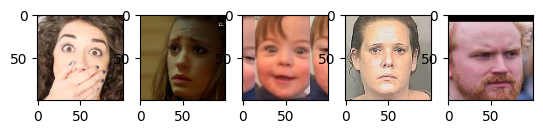

In [15]:
fig, axs = plt.subplots(1,5)

for index, ax in enumerate(axs.ravel()):
    ax.imshow(Images[index])
    
fig.show()

In [16]:
X_images_np.shape

(6975, 100, 100, 3)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_images_np, y_np, test_size=0.3, random_state=123, stratify=y)

In [18]:
X_train.shape

(4882, 100, 100, 3)

In [19]:
y_train

array([3, 1, 3, ..., 3, 3, 1])

In [20]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

In [21]:
model = Sequential()
model.add(Conv2D(10, (10, 10), activation = 'relu', input_shape=(100, 100, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(20, (10, 10), activation = 'relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(500, activation = 'relu'))
model.add(Dense(5, activation = 'log_softmax'))

/home/adam/anaconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1733067971.438611     898 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4701 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1


In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 91, 91, 10)     │         3,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 45, 45, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 36, 36, 20)     │        20,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 18, 18, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6480)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │     3,240,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,266,035 (12.46 MB)

 Trainable params: 3,266,035 (12.46 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [24]:
history = model.fit(X_train, y_train, epochs=10)

2024-12-01 16:46:13.712121: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 585840000 exceeds 10% of free system memory.
2024-12-01 16:46:14.180620: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 585840000 exceeds 10% of free system memory.


Epoch 1/10


I0000 00:00:1733067975.598362    1149 service.cc:148] XLA service 0x7f13e400ba30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733067975.599193    1149 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 with Max-Q Design, Compute Capability 6.1
2024-12-01 16:46:15.657387: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733067975.839053    1149 cuda_dnn.cc:529] Loaded cuDNN version 90300


 14/153 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2485 - loss: 1.6803

I0000 00:00:1733067978.515302    1149 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


153/153 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.3408 - loss: 1.4533
Epoch 2/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5519 - loss: 1.0363
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6129 - loss: 0.9082
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6928 - loss: 0.7573
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7745 - loss: 0.5705
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8277 - loss: 0.4464
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8972 - loss: 0.2927
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9304 - loss: 0.2193
Epoch 9/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9615 - loss: 0.1240
Epoch 10/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9801 - loss: 0.0785


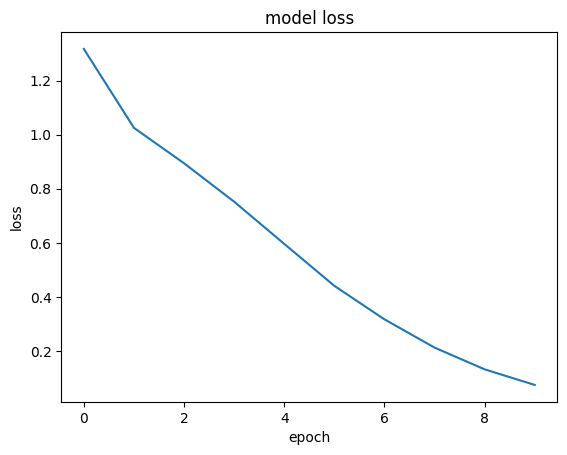

In [25]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [26]:
np.exp(model.predict(np.array([X_train[0]])))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


array([[0.00190451, 0.02648518, 0.00808054, 0.93118054, 0.03234918]],
      dtype=float32)

In [27]:
y_train[0]

np.int64(3)

In [28]:
model.evaluate(X_test, y_test)

2024-12-01 16:46:38.788333: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 251160000 exceeds 10% of free system memory.
2024-12-01 16:46:38.964843: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 251160000 exceeds 10% of free system memory.


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6217 - loss: 1.8382


[1.9269875288009644, 0.5996177792549133]

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [30]:
y_pred = np.exp(model.predict(X_test))

2024-12-01 16:46:41.095390: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 251160000 exceeds 10% of free system memory.


66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [31]:
y_pred

array([[2.0377129e-06, 1.5423866e-02, 4.6671983e-02, 9.3790215e-01,
        9.9007243e-12],
       [9.9999917e-01, 8.3195471e-07, 3.2794201e-10, 1.8116950e-08,
        4.8408756e-14],
       [1.2252591e-10, 2.3030753e-01, 1.6607079e-04, 7.6951516e-01,
        1.1177554e-05],
       ...,
       [2.3195268e-09, 3.1154859e-01, 5.5111509e-06, 6.8337840e-01,
        5.0674728e-03],
       [1.9010056e-03, 1.4691876e-01, 6.0034997e-04, 8.5057038e-01,
        9.4457255e-06],
       [1.7563229e-03, 8.5815728e-01, 4.0697614e-03, 1.3600905e-01,
        7.5988851e-06]], dtype=float32)

In [32]:
y_pred_max = np.argmax(y_pred, axis=1)

In [33]:
y_pred_max

array([3, 0, 3, ..., 3, 3, 1])

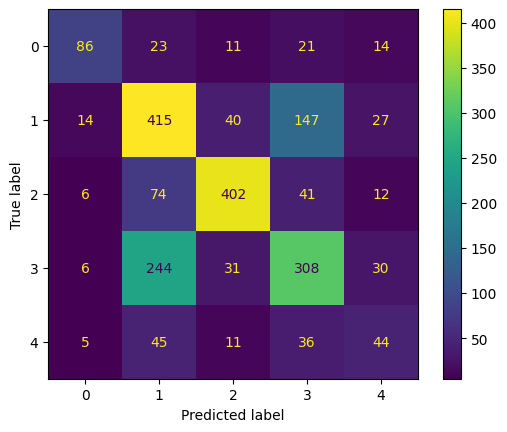

In [34]:
matrix = confusion_matrix(y_test, y_pred_max)
ConfusionMatrixDisplay(matrix).plot()
plt.show()

In [300]:
@tf.function(input_signature=[tf.TensorSpec(shape=(None), dtype=tf.string)])
def pre_and_pro_process(images_bytes):
    def preprocess(image_bytes):
        len_img = tf.strings.length(image_bytes)
        image_raw = tf.strings.substr(image_bytes, pos=2, len=len_img - 3)
        image_raw = tf.io.decode_base64(image_raw)
        image = tf.image.decode_image(image_raw, channels=3, expand_animations = False)
        image = tf.image.resize(image, [100, 100])
        image = image / 255.0

        return image
        
    # preprocess
    images = tf.map_fn(preprocess, images_bytes, dtype=tf.float32)

    # predict
    predictions = tf.math.exp(model(images))

    # postprocess
    def map_to_dict(prediction):
        emotions = ['Surprise', 'Sad', 'Happy', 'Neutral', 'Angry']
        prediction_strings = tf.strings.as_string(prediction)
        pairs = tf.stack([emotions, prediction_strings], axis=1)

        def join_pair(pair):
            return tf.strings.join([pair[0], ": ", pair[1]])  # Convert "class1: value"

        joined_pairs = tf.map_fn(join_pair, pairs, dtype=tf.string)

        result = tf.strings.join(["{",tf.strings.reduce_join(joined_pairs, separator=", "), "}"])
        return result
        
    formatted_predictions = tf.map_fn(map_to_dict, predictions, dtype=tf.string)
    
    return formatted_predictions      

In [48]:
import json
import base64

In [301]:
with open("happy.jpg", "rb") as image_file:
    a = base64.urlsafe_b64encode(image_file.read())
    a = tf.constant([str(a)])

print(pre_and_pro_process(a))

with open("happy.jpg", "rb") as image_file:
    r = str(base64.urlsafe_b64encode(image_file.read()))
    request = json.dumps({"instances": [r]})
    #print(request)

# =']
# [b'_9

tf.Tensor([b'{Surprise: 0.000000, Sad: 0.000539, Happy: 0.915597, Neutral: 0.000001, Angry: 0.083864}'], shape=(1,), dtype=string)


In [302]:
#tf.saved_model.save(
    #model,
    #"model_store_tf/1/",
    #signatures={"serving_default": pre_and_pro_process}
#)

export_archive = ExportArchive()
export_archive.track(model)
export_archive.add_endpoint(name="serve", fn=pre_and_pro_process)
export_archive.write_out("model_store_tf/1/")

INFO:tensorflow:Assets written to: model_store_tf/1/assets


INFO:tensorflow:Assets written to: model_store_tf/1/assets


Saved artifact at 'model_store_tf/1/'. The following endpoints are available:

* Endpoint 'serve'
  images_bytes (POSITIONAL_OR_KEYWORD): TensorSpec(shape=<unknown>, dtype=tf.string, name=None)
Output Type:
  TensorSpec(shape=(None,), dtype=tf.string, name=None)
Captures:
  139728768990576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139728768983184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139728767457008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139728767451200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139728767460704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139728767465632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139728767465984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139728767649216: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [77]:
#model.export("model_store_tf/1/")

In [112]:
import os
os.path.abspath("model_store_tf")

'/home/adam/Bachelor/model_store_tf'

{"instances": ["b''"]}
